CocaCola

In [1]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'xgboost'

In [2]:
store = pd.read_excel('CocaCola_Sales_Rawdata.xlsx')

In [3]:
store.head()

,Quarter,Sales
0,Q1_86,1734.827000
1,Q2_86,2244.960999
2,Q3_86,2533.804993
3,Q4_86,2154.962997
4,Q1_87,1547.818996


In [4]:
quarter=['Q1','Q2','Q3','Q4']
n=store['Quarter'][0]
n[0:2]

store['quarter']=0

In [5]:
for i in range(42):
    n=store['Quarter'][i]
    store['quarter'][i]=n[0:2]

<ipython-input-5-7aa52946d682>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store['quarter'][i]=n[0:2]
C:\Users\Hemanth H L\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
dummy=pd.DataFrame(pd.get_dummies(store['quarter']))

In [7]:
coco=pd.concat((store,dummy),axis=1)
t= np.arange(1,43)
coco['t']=t
coco['t_square']=coco['t']*coco['t']

In [8]:
log_Sales=np.log(coco['Sales'])
coco['log_Sales']=log_Sales

<AxesSubplot:>

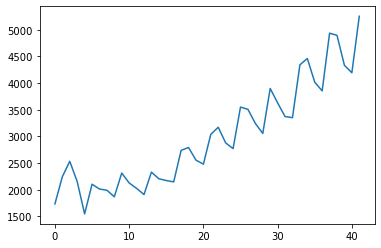

In [9]:
train= coco.head(38)
test=coco.tail(4)
coco.Sales.plot()

In [10]:
import statsmodels.formula.api as smf


linear= smf.ols('Sales~t',data=train).fit()
predlin=pd.Series(linear.predict(pd.DataFrame(test['t'])))
rmselin=np.sqrt((np.mean(np.array(test['Sales'])-np.array(predlin))**2))
rmselin

421.17878760022813

In [11]:
quad=smf.ols('Sales~t+t_square',data=train).fit()
predquad=pd.Series(quad.predict(pd.DataFrame(test[['t','t_square']])))
rmsequad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predquad))**2))
rmsequad

475.561835183161

In [12]:
expo=smf.ols('log_Sales~t',data=train).fit()
predexp=pd.Series(expo.predict(pd.DataFrame(test['t'])))
predexp
rmseexpo=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predexp)))**2))
rmseexpo

466.24797310672005

In [13]:
additive= smf.ols('Sales~ Q1+Q2+Q3+Q4',data=train).fit()
predadd=pd.Series(additive.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
predadd
rmseadd=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predadd))**2))
rmseadd

1860.0238154547278

In [14]:
addlinear= smf.ols('Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predaddlinear=pd.Series(addlinear.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
predaddlinear

rmseaddlinear=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddlinear))**2))
rmseaddlinear

464.9829023982251

In [15]:
addquad=smf.ols('Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
predaddquad=pd.Series(addquad.predict(pd.DataFrame(test[['t','t_square','Q1','Q2','Q3','Q4']])))
rmseaddquad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(predaddquad))**2))
rmseaddquad

301.7380071934879

In [16]:
mulsea=smf.ols('log_Sales~Q1+Q2+Q3+Q4',data=train).fit()
predmul= pd.Series(mulsea.predict(pd.DataFrame(test[['Q1','Q2','Q3','Q4']])))
rmsemul= np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmul)))**2))
rmsemul

1963.3896400779759

In [17]:
mullin= smf.ols('log_Sales~t+Q1+Q2+Q3+Q4',data=train).fit()
predmullin= pd.Series(mullin.predict(pd.DataFrame(test[['t','Q1','Q2','Q3','Q4']])))
rmsemulin=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(predmullin)))**2))
rmsemulin

225.52439049826702

In [18]:
mul_quad= smf.ols('log_Sales~t+t_square+Q1+Q2+Q3+Q4',data=train).fit()
pred_mul_quad= pd.Series(mul_quad.predict(test[['t','t_square','Q1','Q2','Q3','Q4']]))
rmse_mul_quad=np.sqrt(np.mean((np.array(test['Sales'])-np.array(np.exp(pred_mul_quad)))**2))
rmse_mul_quad

581.8457187961433

In [19]:
data={'Model':pd.Series(['rmse_mul_quad','rmseadd','rmseaddlinear','rmseaddquad','rmseexpo','rmselin','rmsemul','rmsemulin','rmsequad']),'Values':pd.Series([rmse_mul_quad,rmseadd,rmseaddlinear,rmseaddquad,rmseexpo,rmselin,rmsemul,rmsemulin,rmsequad])}
data

{'Model': 0    rmse_mul_quad
 1          rmseadd
 2    rmseaddlinear
 3      rmseaddquad
 4         rmseexpo
 5          rmselin
 6          rmsemul
 7        rmsemulin
 8         rmsequad
 dtype: object,
 'Values': 0     581.845719
 1    1860.023815
 2     464.982902
 3     301.738007
 4     466.247973
 5     421.178788
 6    1963.389640
 7     225.524390
 8     475.561835
 dtype: float64}

In [20]:
Rmse=pd.DataFrame(data)
Rmse

,Model,Values
0,rmse_mul_quad,581.845719
1,rmseadd,1860.023815
2,rmseaddlinear,464.982902
3,rmseaddquad,301.738007
4,rmseexpo,466.247973
5,rmselin,421.178788
6,rmsemul,1963.389640
7,rmsemulin,225.524390
8,rmsequad,475.561835


C:\Users\Hemanth H L\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sales'>

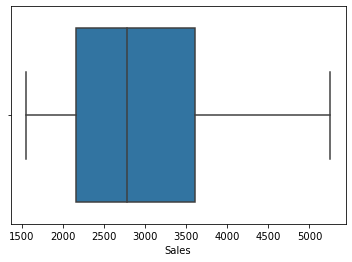

In [21]:
sns.boxplot("Sales",data=store)

C:\Users\Hemanth H L\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\Hemanth H L\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


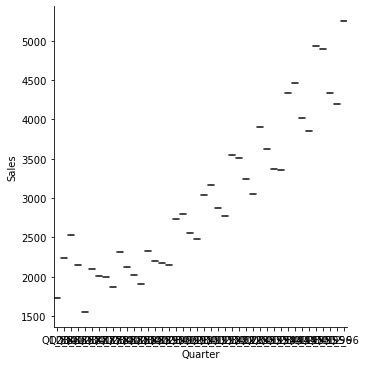

In [22]:
sns.factorplot("Quarter","Sales",data=store,kind="box")

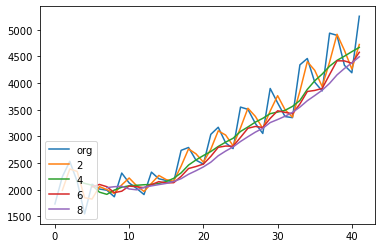

In [23]:
store.Sales.plot(label="org")
for i in range(2,10,2):
    store["Sales"].rolling(i).mean().plot(label=str(i))
plt.legend(loc=3)

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
import statsmodels.graphics.tsaplots as tsa_plots
import statsmodels.tsa.statespace as tm_models
from datetime import datetime,time

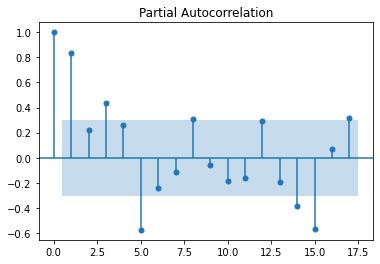

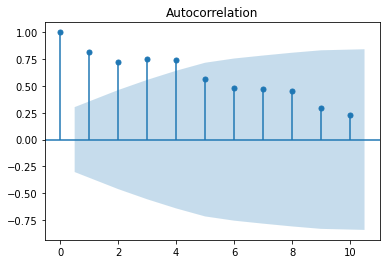

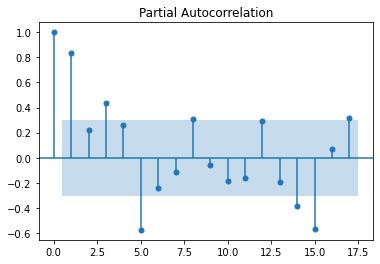

In [25]:
tsa_plots.plot_acf(store.Sales,lags=10)
tsa_plots.plot_pacf(store.Sales)

In [26]:
Train = store.head(48)
Test =store.tail(12)

In [27]:
def MAPE(pred,org):
    temp = np.abs((pred-org))*100/org
    return np.mean(temp)

In [28]:
ses_model = SimpleExpSmoothing(Train["Sales"]).fit()
pred_ses = ses_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_ses,Test.Sales)

C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


9.68200492651463

In [29]:
hw_model = Holt(Train["Sales"]).fit()
pred_hw = hw_model.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hw,Test.Sales)

11.025182440957998

In [30]:
hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_add_add,Test.Sales)

<ipython-input-30-3efabb31019e>:1: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  hwe_model_add_add = ExponentialSmoothing(Train["Sales"],seasonal="add",trend="add",seasonal_periods=4,damped=True).fit()


3.245837019668915

In [31]:
hwe_model_mul_add = ExponentialSmoothing(Train["Sales"],seasonal="mul",trend="add",seasonal_periods=4).fit()
pred_hwe_mul_add = hwe_model_mul_add.predict(start = Test.index[0],end = Test.index[-1])
MAPE(pred_hwe_mul_add,Test.Sales) 

2.8845556504947196

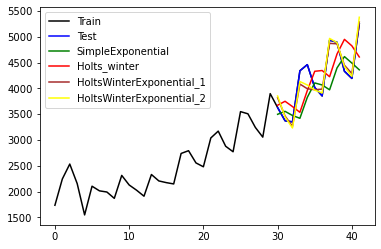

In [32]:
plt.plot(Train.index, Train["Sales"], label='Train',color="black")
plt.plot(Test.index, Test["Sales"], label='Test',color="blue")
plt.plot(pred_ses.index, pred_ses, label='SimpleExponential',color="green")
plt.plot(pred_hw.index, pred_hw, label='Holts_winter',color="red")
plt.plot(pred_hwe_add_add.index,pred_hwe_add_add,label="HoltsWinterExponential_1",color="brown")
plt.plot(pred_hwe_mul_add.index,pred_hwe_mul_add,label="HoltsWinterExponential_2",color="yellow")
plt.legend(loc='best')

Airlines Passengers

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6

dataset = pd.read_excel("Airlines+Data.xlsx")
dataset.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [35]:
dataset['Month'] = pd.to_datetime(dataset['Month'], infer_datetime_format=True)
indexedDataset = dataset.set_index(['Month'])

In [36]:
from datetime import datetime
indexedDataset['1995-03']
indexedDataset['1995-03':'1995-06']
indexedDataset['1995']

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121
1995-06-01,135
1995-07-01,148
1995-08-01,148
1995-09-01,136


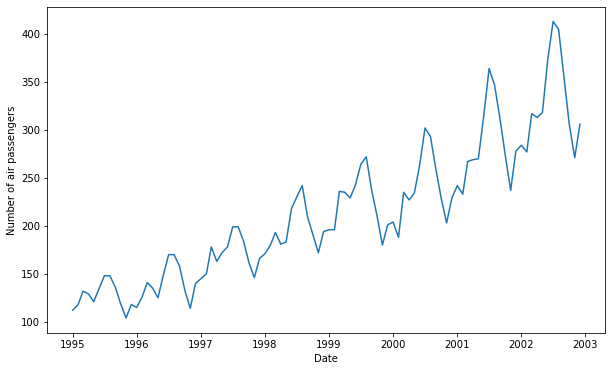

In [37]:
plt.xlabel("Date")
plt.ylabel("Number of air passengers")
plt.plot(indexedDataset)

In [38]:
rolmean = indexedDataset.rolling(window=12).mean()
rolstd = indexedDataset.rolling(window=12).std()
print(rolmean, rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


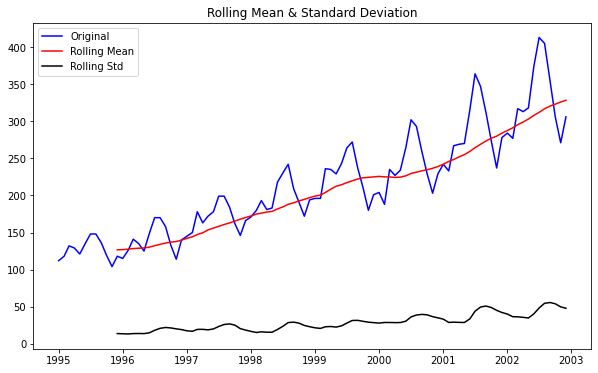

In [39]:
orig = plt.plot(indexedDataset, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [40]:
from statsmodels.tsa.stattools import adfuller

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


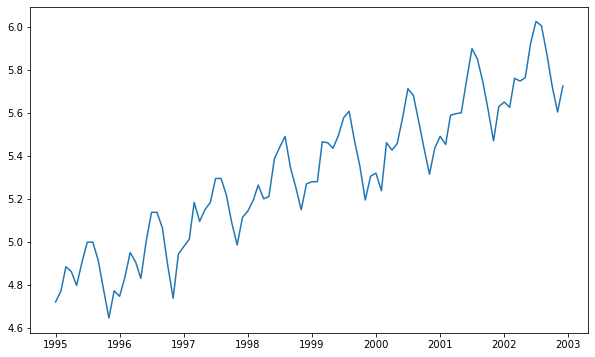

In [41]:
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

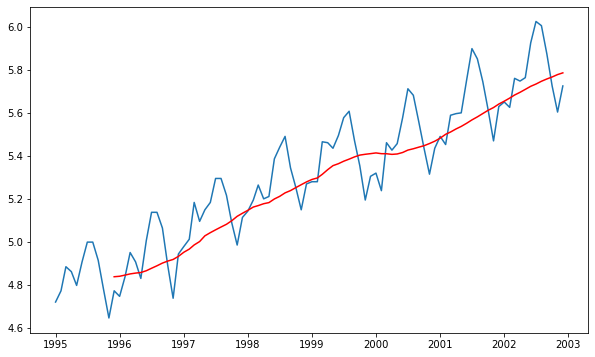

In [42]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [43]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)
#Remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566
1996-03-01,0.099416
1996-04-01,0.052142
1996-05-01,-0.027529
1996-06-01,0.139881
1996-07-01,0.260184
1996-08-01,0.248635


In [44]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

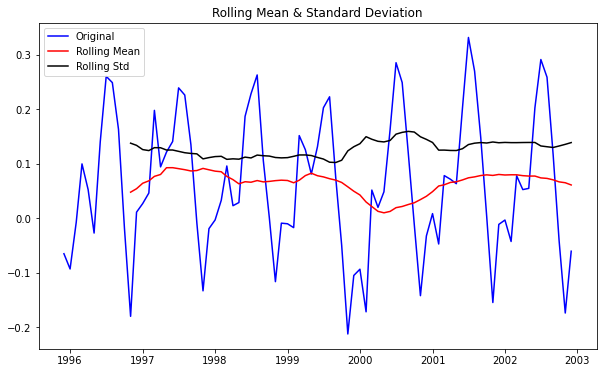

Results of Dickey-Fuller Test:
Test Statistic                 -1.910930
p-value                         0.326937
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [45]:
test_stationarity(datasetLogScaleMinusMovingAverage)

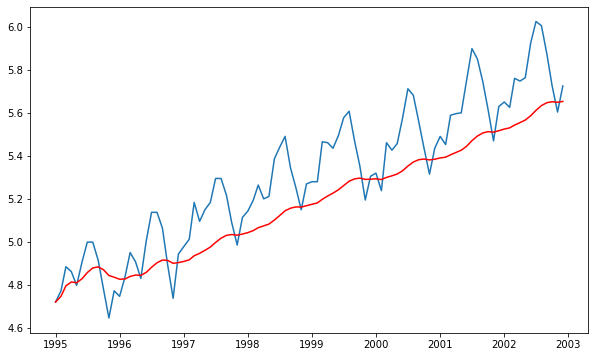

In [46]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

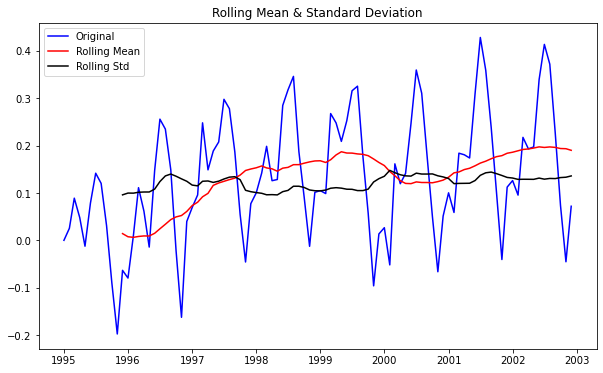

Results of Dickey-Fuller Test:
Test Statistic                 -2.835036
p-value                         0.053441
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


In [47]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

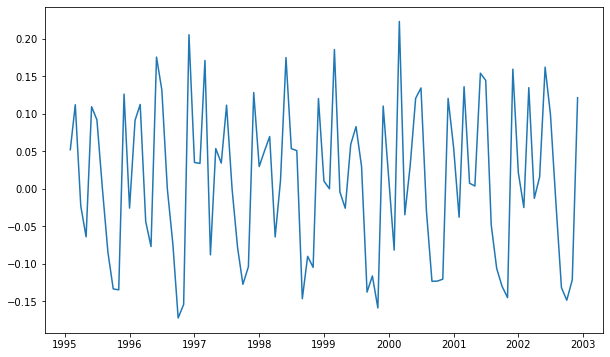

In [48]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

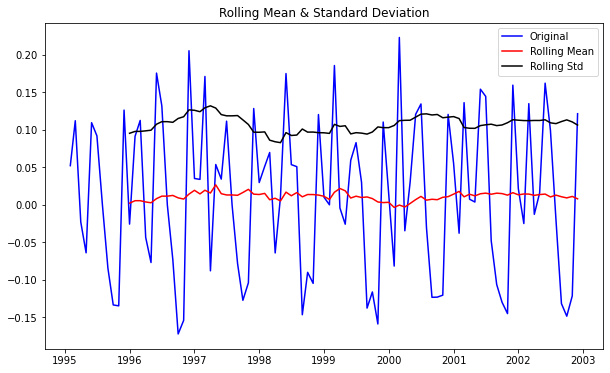

Results of Dickey-Fuller Test:
Test Statistic                 -2.670823
p-value                         0.079225
#Lags Used                     12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


In [49]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

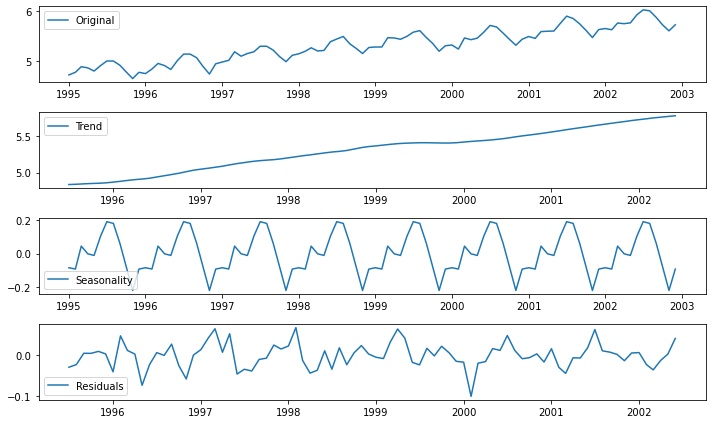

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

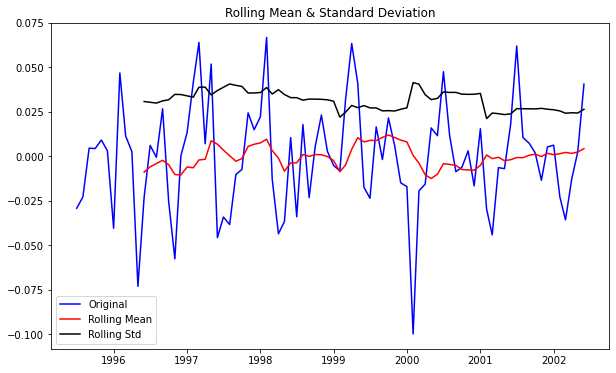

Results of Dickey-Fuller Test:


KeyError: 'Passengers'

In [51]:
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


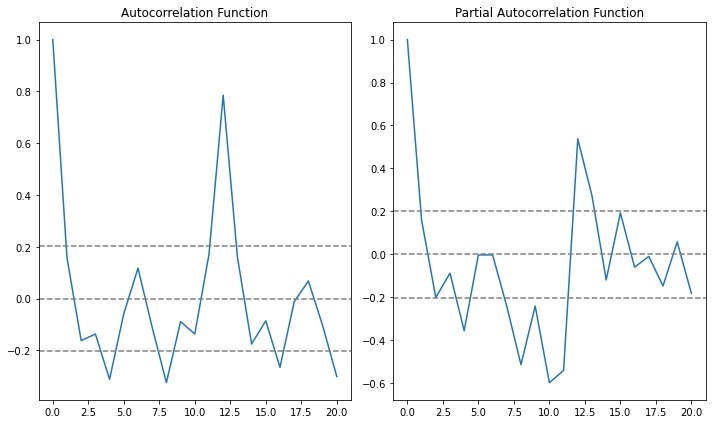

In [52]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')


#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred fre

Plotting AR model


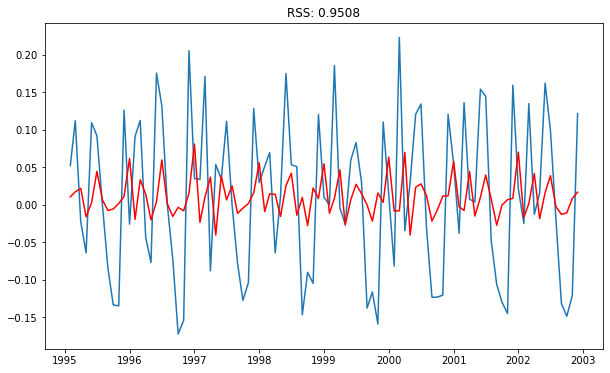

In [53]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(indexedDataset_logScale, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Plotting AR model


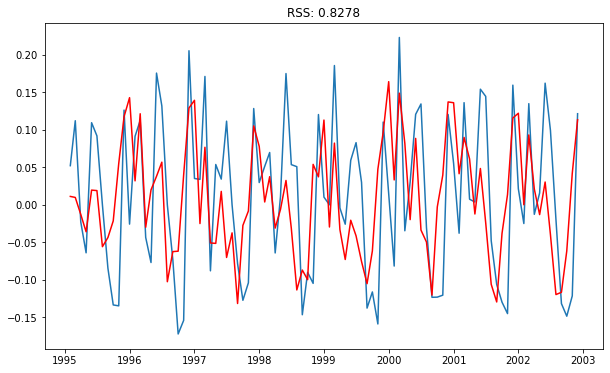

In [54]:
model = ARIMA(indexedDataset_logScale, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))
print('Plotting AR model')

C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Hemanth H L\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed,

Text(0.5, 1.0, 'RSS: 0.6931')

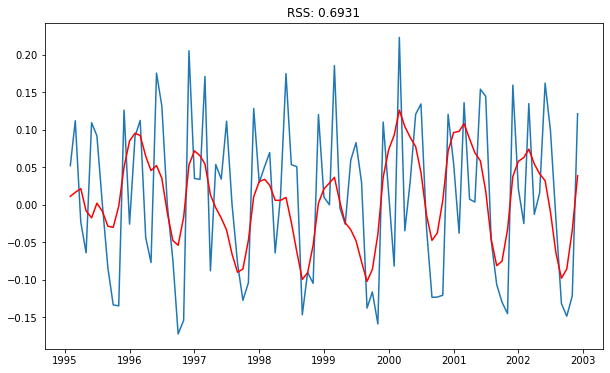

In [55]:
model = ARIMA(indexedDataset_logScale, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting["Passengers"])**2))

In [56]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
1995-02-01    0.011261
1995-03-01    0.016603
1995-04-01    0.021666
1995-05-01   -0.008096
1995-06-01   -0.017398
dtype: float64


In [57]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

Month
1995-02-01    0.011261
1995-03-01    0.027864
1995-04-01    0.049530
1995-05-01    0.041434
1995-06-01    0.024036
dtype: float64


In [58]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'], index=indexedDataset_logScale['Passengers'].index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1995-01-01    4.718499
1995-02-01    4.781945
1995-03-01    4.910666
1995-04-01    4.909343
1995-05-01    4.837225
dtype: float64

Text(0.5, 1.0, 'RMSE: 221.4314')

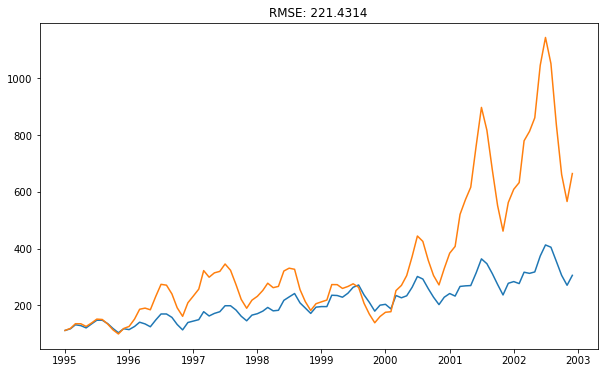

In [59]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-indexedDataset["Passengers"])**2)/len(indexedDataset["Passengers"])))